## Imports and data path

In [1]:
%load_ext autoreload
%reload_ext autoreload
from VehicleDetection import VehicleDetection
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import copy
from eval_utils import *
from video_utils import *

data_path = '../datasets/AICity_data/train/S03/c010/'


## Function to read detections files

In [2]:
def readDetections(path):
  #Generates detection dictionary where the frame number is the key and the values are the info of the corresponding detection/s
  
    with open(path) as f:
        lines = f.readlines()

    detections = {}
    for line in lines:
        data = line.split(',')
        if data[0] in detections:
            detections[data[0]].append(VehicleDetection(int(data[0]), int(data[1]), float(data[2]), float(data[3]), float(data[4]), float(data[5]), float(data[6])))
        else:
            detections[data[0]] = [VehicleDetection(int(data[0]), int(data[1]), float(data[2]), float(data[3]), float(data[4]), float(data[5]), float(data[6]))]

    return detections

## Functions to add noise in box size & placement

In [3]:
def resize(d, stdv):
    randNoiseVal = np.random.normal(0, stdv, size=(2,))
    dAux = copy.deepcopy(d)
    dAux.w += randNoiseVal[0]
    dAux.h += randNoiseVal[1]
    dAux.xtl -= randNoiseVal[0]/2
    dAux.ytl -= randNoiseVal[1]/2
    dAux.xbr = dAux.xtl + dAux.w
    dAux.ybr = dAux.ytl + dAux.h
    
    return dAux

def displacement(d, stdv):
    randNoiseVal = np.random.normal(0, stdv, size=(2,))
    dAux = copy.deepcopy(d)
    dAux.xtl += randNoiseVal[0]
    dAux.ytl += randNoiseVal[1]
    dAux.xbr = dAux.xtl + dAux.w
    dAux.ybr = dAux.ytl + dAux.h
    
    return dAux

In [4]:
def noise(detections, doResize, resizeStdv, doDisplacement, displacementStdv):
    newBoxes = {}
    for frame, ds, in detections.items():
        newBoxes[frame] = []
        for d in ds:
            if doResize == True:
                d = resize(d, resizeStdv)
            if doDisplacement == True:
                d = displacement(d, displacementStdv)

            newBoxes[frame].append(d)

    return newBoxes

## Functions to delete/generate bounding boxes

In [5]:
imgSize = [1920, 1080]
minBoxDim = 10
maxBoxDim = 200

In [6]:
def del_gen(detections, delProb, genProb, genType):
    newBoxes = {}

    for frame, ds, in detections.items():
        newBoxes[frame] = []

        # Box deletion
        for d in ds:
            randNum1 = np.random.rand()
            dAux = copy.deepcopy(d)
            if randNum1 > delProb:
                newBoxes[frame].append(dAux)
            else:
                pass # Deleted if probability condition is met

            # Box generation
            randNum2 = np.random.rand()
            if randNum2 <= genProb: #Proceed to creation of bounding box if probability condition is met
                dNew = copy.deepcopy(dAux)
                if genType == "over": #Box created as a "noisy" version of existing detection
                    dNew = resize(dNew)
                    dNew = displacement(dNew)
                elif genType == "random": #Box created based on random placement and size
                    dNew.xtl = np.random.uniform(0, imgSize[0]-minBoxDim)
                    dNew.ytl = np.random.uniform(0, imgSize[1]-minBoxDim)
                    dNew.xbr = np.random.uniform(dNew.xtl+minBoxDim, imgSize[0])
                    dNew.ybr = np.random.uniform(dNew.ytl+minBoxDim, imgSize[1])

                newBoxes[frame].append(dNew)

    return newBoxes

## Reading detections

In [6]:
gt_detect = readDetections(data_path + 'gt/gt.txt')

## Adding noise and generation/deletion of boxes

In [15]:
# Adjust settings for alterations:

applyNoise = True
doResize = True
resizeStdv = 30
doDisplacement = False
displacementStdv = 30

applyDelgen = False
delProb = 0.1
genProb = 0.1
genType = "over" #Select between over or random

In [16]:
def add_alterations(gt_detect, applyNoise, doResize, resizeStdv, doDisplacement, displacementStdv, applyDelgen, delProb, genProb, genType):
    gt_altered = gt_detect
    if applyNoise == True:
        gt_altered = noise(gt_altered, doResize, resizeStdv, doDisplacement, displacementStdv)
    if applyDelgen == True:
        gt_altered = del_gen(gt_altered, delProb, genProb, genType)
    
    return gt_altered

In [17]:
gt_altered = add_alterations(gt_detect, applyNoise, doResize, resizeStdv, doDisplacement, displacementStdv, applyDelgen, delProb, genProb, genType)

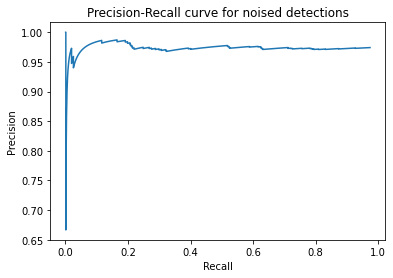

In [18]:
#solution for noisy GT example
rec, prec, ap, tp_Noise = voc_eval(gt_detect, gt_altered, 0.5, True)

plot_prec_recall_curve(prec, rec, 'Precision-Recall curve for noised detections')

In [20]:
generate_videoBB_comparison(data_path + 'vdo.avi', gt_detect, gt_altered, 'noised_GT', 250, 255)

100%|██████████████████████████████████████| 2141/2141 [00:19<00:00, 111.18it/s]


OSError: [Errno 28] No space left on device

## Evaluating mAP for Mask RCNN, SSD512 and Yolo3

In [7]:
yolo3_dect = readDetections(data_path + 'det/det_yolo3.txt')

In [ ]:
rec, prec, ap, tp_yolo3 = voc_eval(gt_detect, yolo3_dect, 0.5, False)

plot_prec_recall_curve(prec, rec, f'Precision-Recall curve for yolo3 detections - AP {ap}')

In [12]:
ssd512_dect = readDetections(data_path + 'det/det_ssd512.txt')

In [ ]:
rec, prec, ap, tp_SSD512 = voc_eval(gt_detect, ssd512_dect, 0.5, True)

plot_prec_recall_curve(prec, rec, f'Precision-Recall curve for ssd512 detections - AP {ap}')

## Multiple random shuffle of predictions for cases without confidence values

In [ ]:
N = 10
recs, precs, aps = ap_wo_conf(gt_detect, yolo3_dect, N, 0.5)
print(f'Average precision {np.mean(aps)}')
labels = [('Random trial ' + str(i)) for i in range(N)]
plot_multiple_prec_recall_curves(precs, recs, labels)

None vs Confidence vs N shuffles

Average precision 0.257205863040101


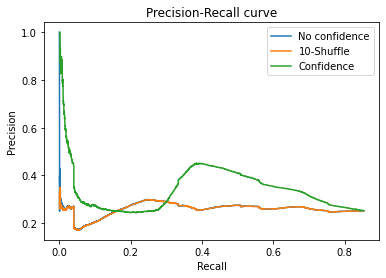

In [13]:
#No confidence
rec_nc, prec_nc, ap_nc, _ = voc_eval(gt_detect, yolo3_dect, 0.5, False)

#No confidence but multiple shuffles
N = 10
recs, precs, aps = ap_wo_conf(gt_detect, yolo3_dect, N, 0.5)
print(f'Average precision {np.mean(aps)}')
precs_array = np.array(precs)
precs_average = np.mean(precs, axis=0)

#Confiedence
rec_c, prec_c, ap_c, _ = voc_eval(gt_detect, yolo3_dect, 0.5, True)


plot_multiple_prec_recall_curves([prec_nc, precs_average, prec_c], recs[0:3], ['No confidence', f'{N}-Shuffle', 'Confidence'], 'YOLO3 Precision comparison')

In [ ]:
#No confidence
rec_nc, prec_nc, ap_nc, _ = voc_eval(gt_detect, ssd512_dect, 0.5, False)

#No confidence but multiple shuffles
N = 10
recs, precs, aps = ap_wo_conf(gt_detect, ssd512_dect, N, 0.5)
print(f'Average precision {np.mean(aps)}')
precs_array = np.array(precs)
precs_average = np.mean(precs, axis=0)

#Confiedence
rec_c, prec_c, ap_c, _ = voc_eval(gt_detect, ssd512_dect, 0.5, True)


plot_multiple_prec_recall_curves([prec_nc, precs_average, prec_c], recs[0:3], ['No confidence', f'{N}-Shuffle', 'Confidence'], 'YOLO3 Precision comparison')